In [42]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')

In [43]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')

In [44]:
# Load the dataset
df = pd.read_csv('wayfair.csv')

In [45]:
# Display basic information
print(f"Dataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns\n")

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Column information
print("\nColumn information:")
df.info()

Dataset dimensions: 123542 rows and 18 columns

First 5 rows of the dataset:


,Customer_Session_Start_Date,Order_ID,Order_Product_ID,Product_ID,Purchased_Qty,Returned_Qty,Cancelled,Guarantee_Shown,Product_Category,Total_Order_Value,Customer_Estimated_Delivery_Date,Customer_Actual_Delivery_Date,Visitor_Type_ID,Vistor_Type_Name,Platform_ID,Platform_Name,Customer_ID,ShipClassName
0,2016-12-18 00:00:00,56795_22504,2406126045,1743317681120120064,1,0,0,0,Heating & Grills,150 - 200,2017-01-20 19:08:13,2017-01-20 10:21:42,4,Activated Customer,1,Desktop,19830053,Small Parcel
1,2016-12-19 00:00:00,05922_23349,2268892442,7819236675163079680,1,0,0,0,Lighting,250 - 300,2016-12-23 00:00:00,2016-12-23 00:00:00,2,Returning Visitor,1,Desktop,17177128,Small Parcel
2,2016-12-17 00:00:00,12952_23336,2266865412,5928089172568630272,1,0,0,1,Kitchen,80 - 100,2016-12-20 00:00:00,2016-12-20 14:54:53,4,Activated Customer,2,Mobile Web,13831018,Small Parcel
3,2016-12-12 00:00:00,82302_23303,2260935702,4719064645483639808,1,0,0,0,Lighting,40 - 60,2016-12-15 00:00:00,2016-12-15 00:00:00,4,Activated Customer,2,Mobile Web,16128551,Small Parcel
4,2016-12-17 00:00:00,70253_23719,1854293603,6657947175955829760,1,1,0,0,Seasonal Decor,0 - 20,2016-12-27 00:00:00,2016-12-27 10:04:00,1,New Visitor,1,Desktop,17271349,Small Parcel



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123542 entries, 0 to 123541
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Customer_Session_Start_Date       123542 non-null  object
 1   Order_ID                          123542 non-null  object
 2   Order_Product_ID                  123542 non-null  int64 
 3   Product_ID                        123542 non-null  int64 
 4   Purchased_Qty                     123542 non-null  int64 
 5   Returned_Qty                      123542 non-null  int64 
 6   Cancelled                         123542 non-null  int64 
 7   Guarantee_Shown                   123542 non-null  int64 
 8   Product_Category                  123525 non-null  object
 9   Total_Order_Value                 123542 non-null  object
 10  Customer_Estimated_Delivery_Date  123474 non-null  object
 11  Customer_Actual_Delivery_Date     119838 non

In [46]:
# Check for missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
display(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


Missing values in each column:


,Missing Values,Percentage
Customer_Actual_Delivery_Date,3704,2.998171
Customer_Estimated_Delivery_Date,68,0.055042
Product_Category,17,0.013761


In [47]:
# Customer_Actual_Delivery_Date	missing values solutions
date_columns = ['Customer_Session_Start_Date', 'Customer_Estimated_Delivery_Date', 'Customer_Actual_Delivery_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [48]:
# Extract order value from ranges (e.g., "150 - 200") and adding them up to get an specific average price
def extract_order_value(value_str):
    try:
        if isinstance(value_str, str) and '-' in value_str:
            values = [float(v.strip()) for v in value_str.split('-')]
            return sum(values) / len(values)
        else:
            return float(value_str)
    except:
        return np.nan

df['Order_Value_Numeric'] = df['Total_Order_Value'].apply(extract_order_value)
df['Order_Value_Numeric']

0         175.0
1         275.0
2          90.0
3          50.0
4          10.0
          ...  
123537    275.0
123538    350.0
123539    125.0
123540    275.0
123541    350.0
Name: Order_Value_Numeric, Length: 123542, dtype: float64

In [49]:


# Delivery-related features
df['Est_Delivery_Days'] = (df['Customer_Estimated_Delivery_Date'] - df['Customer_Session_Start_Date']).dt.days
df['Actual_Delivery_Days'] = (df['Customer_Actual_Delivery_Date'] - df['Customer_Session_Start_Date']).dt.days
df['Delivery_Delay_Days'] = (df['Customer_Actual_Delivery_Date'] - df['Customer_Estimated_Delivery_Date']).dt.days

# Classify deliveries
df['Delivery_Status'] = np.where(
    df['Customer_Actual_Delivery_Date'].isna(), 'Unknown',
    np.where(
        df['Delivery_Delay_Days'] < 0, 'Early',
        np.where(
            df['Delivery_Delay_Days'] == 0, 'On Time', 'Late'
        )
    )
)
 #Create binary flags that show Order Status
df['Has_Return'] = np.where(df['Returned_Qty'] > 0, 1, 0)
df['Is_Cancelled'] = df['Cancelled']
df['Has_Guarantee'] = df['Guarantee_Shown']


## Part 1 : EDA

In [50]:
# General EDA Graphs for Wayfair Dataset
# These are versatile visualizations that work with older matplotlib versions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetics for better visualization
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. Order Volume Distribution by Product Category (Top 10)
def plot_category_distribution():
    plt.figure(figsize=(12, 6))
    category_counts = df['Product_Category'].value_counts().head(10)
    
    # Create horizontal bar chart
    bars = plt.barh(category_counts.index, category_counts.values, color='skyblue')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 100, bar.get_y() + bar.get_height()/2, 
                f'{width:,}', ha='left', va='center')
    
    plt.title('Order Volume by Product Category (Top 10)', fontsize=14)
    plt.xlabel('Number of Orders', fontsize=12)
    plt.ylabel('Product Category', fontsize=12)
    plt.tight_layout()
    plt.show()

# 2. Platform Distribution (Desktop vs. Mobile)
def plot_platform_distribution():
    plt.figure(figsize=(10, 6))
    platform_counts = df['Platform_Name'].value_counts()
    
    # Create pie chart
    plt.pie(platform_counts, labels=platform_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=['#4dabf7', '#ff6b6b'], explode=(0.05, 0))
    
    plt.title('Order Distribution by Platform', fontsize=14)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    
    # Add absolute counts as a legend
    legend_labels = [f'{name}: {count:,} orders' 
                    for name, count in zip(platform_counts.index, platform_counts.values)]
    plt.legend(legend_labels, loc='lower left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 3. Distribution of Order Values
def plot_order_value_distribution():
    plt.figure(figsize=(12, 6))
    
    # Create price bins
    bins = [0, 50, 100, 150, 200, 250, 300, 500, 700]
    labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-500', '500+']
    
    df['Price_Range'] = pd.cut(df['Order_Value_Numeric'], bins=bins, labels=labels)
    price_dist = df['Price_Range'].value_counts().sort_index()
    
    # Plot
    ax = price_dist.plot(kind='bar', color='lightseagreen')
    
    # Add value labels
    for i, v in enumerate(price_dist):
        ax.text(i, v + 100, f'{v:,}', ha='center')
    
    plt.title('Distribution of Order Values', fontsize=14)
    plt.xlabel('Order Value Range ($)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Customer Type Distribution
def plot_customer_distribution():
    plt.figure(figsize=(12, 6))
    customer_counts = df['Vistor_Type_Name'].value_counts()
    
    # Create pie chart
    plt.pie(customer_counts, labels=None, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Set3", len(customer_counts)))
    
    plt.title('Order Distribution by Customer Type', fontsize=14)
    plt.axis('equal')
    
    # Create legend with counts
    legend_labels = [f'{name} ({count:,})' 
                    for name, count in zip(customer_counts.index, customer_counts.values)]
    plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 5. Return Rate by Product Category
def plot_return_rates_by_category():
    plt.figure(figsize=(12, 6))
    
    # Calculate return rate by category (for categories with at least 100 orders)
    category_counts = df['Product_Category'].value_counts()
    valid_categories = category_counts[category_counts >= 100].index.tolist()
    
    category_returns = df[df['Product_Category'].isin(valid_categories)].groupby('Product_Category').agg({
        'Has_Return': 'mean',
        'Order_ID': 'count'
    }).reset_index()
    
    category_returns['Return_Rate'] = category_returns['Has_Return'] * 100
    category_returns = category_returns.sort_values('Return_Rate', ascending=False).head(10)
    
    # Create horizontal bar chart
    bars = plt.barh(category_returns['Product_Category'], category_returns['Return_Rate'], color='salmon')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.2, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}%', ha='left', va='center')
    
    plt.title('Top 10 Categories by Return Rate (min 100 orders)', fontsize=14)
    plt.xlabel('Return Rate (%)', fontsize=12)
    plt.ylabel('Product Category', fontsize=12)
    plt.xlim(0, max(category_returns['Return_Rate']) * 1.2)
    plt.tight_layout()
    plt.show()

# 6. Shipping Class Analysis
def plot_shipping_class_analysis():
    # Calculate metrics by shipping class
    shipping_metrics = df.groupby('ShipClassName').agg({
        'Order_ID': 'count',
        'Has_Return': 'mean',
        'Order_Value_Numeric': 'mean'
    }).reset_index()
    
    shipping_metrics['Return_Rate'] = shipping_metrics['Has_Return'] * 100
    shipping_metrics['Order_Pct'] = (shipping_metrics['Order_ID'] / shipping_metrics['Order_ID'].sum()) * 100
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Order Distribution by Shipping Class
    ax1.pie(shipping_metrics['Order_ID'], labels=shipping_metrics['ShipClassName'], 
           autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", len(shipping_metrics)))
    ax1.set_title('Order Distribution by Shipping Class', fontsize=12)
    ax1.axis('equal')
    
    # Plot 2: Return Rate by Shipping Class
    bars = ax2.bar(shipping_metrics['ShipClassName'], shipping_metrics['Return_Rate'], color='indianred')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                f'{height:.2f}%', ha='center', va='bottom')
    
    ax2.set_title('Return Rate by Shipping Class', fontsize=12)
    ax2.set_xlabel('Shipping Class', fontsize=10)
    ax2.set_ylabel('Return Rate (%)', fontsize=10)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_ylim(0, max(shipping_metrics['Return_Rate']) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
    # Create a third plot for average order value
    plt.figure(figsize=(10, 6))
    bars = plt.bar(shipping_metrics['ShipClassName'], shipping_metrics['Order_Value_Numeric'], color='teal')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
                f'${height:.2f}', ha='center', va='bottom')
    
    plt.title('Average Order Value by Shipping Class', fontsize=14)
    plt.xlabel('Shipping Class', fontsize=12)
    plt.ylabel('Average Order Value ($)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 7. Delivery Time Analysis
def plot_delivery_time_analysis():
    # Filter out NaN values in delivery days
    delivery_df = df.dropna(subset=['Actual_Delivery_Days'])
    delivery_df = delivery_df[delivery_df['Actual_Delivery_Days'] <= 30]  # Remove extreme outliers
    
    plt.figure(figsize=(14, 6))
    
    # Create histogram with KDE
    plt.hist(delivery_df['Actual_Delivery_Days'], bins=30, alpha=0.7, color='cornflowerblue')
    
    plt.title('Distribution of Delivery Time', fontsize=14)
    plt.xlabel('Delivery Days', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add median and mean lines
    median_days = delivery_df['Actual_Delivery_Days'].median()
    mean_days = delivery_df['Actual_Delivery_Days'].mean()
    
    plt.axvline(median_days, color='red', linestyle='--', linewidth=1, label=f'Median: {median_days:.1f} days')
    plt.axvline(mean_days, color='green', linestyle='--', linewidth=1, label=f'Mean: {mean_days:.1f} days')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# 8. Return Rate by Guarantee Status
def plot_guarantee_impact():
    plt.figure(figsize=(10, 6))
    
    # Group by guarantee status
    guarantee_returns = df.groupby('Has_Guarantee').agg({
        'Has_Return': 'mean',
        'Order_ID': 'count'
    }).reset_index()
    
    guarantee_returns['Return_Rate'] = guarantee_returns['Has_Return'] * 100
    guarantee_returns['Guarantee'] = guarantee_returns['Has_Guarantee'].map({0: 'No Guarantee', 1: 'Guarantee Shown'})
    guarantee_returns['Order_Pct'] = guarantee_returns['Order_ID'] / guarantee_returns['Order_ID'].sum() * 100
    
    # Create the bar chart
    bars = plt.bar(guarantee_returns['Guarantee'], guarantee_returns['Return_Rate'], color=['skyblue', 'lightcoral'])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
        
    # Add sample size labels
    for i, row in guarantee_returns.iterrows():
        plt.text(i, -0.5, f'n={row["Order_ID"]:,} ({row["Order_Pct"]:.1f}%)',
                ha='center', va='top', color='dimgrey')
    
    plt.title('Return Rate by Guarantee Status', fontsize=14)
    plt.xlabel('Guarantee Status', fontsize=12)
    plt.ylabel('Return Rate (%)', fontsize=12)
    plt.ylim(0, max(guarantee_returns['Return_Rate']) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 9. Correlation Matrix for Key Numeric Variables
def plot_correlation_matrix():
    # Select numerical columns
    numeric_cols = ['Order_Value_Numeric', 'Purchased_Qty', 'Returned_Qty', 
                   'Cancelled', 'Guarantee_Shown', 'Has_Return', 
                   'Actual_Delivery_Days', 'Est_Delivery_Days']
    
    # Filter columns that exist in the dataframe
    available_cols = [col for col in numeric_cols if col in df.columns]
    
    # Drop rows with NAs in these columns
    corr_df = df[available_cols].dropna()
    
    # Compute correlation matrix
    corr_matrix = corr_df.corr()
    
    plt.figure(figsize=(12, 10))
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Draw heatmap
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, 
               fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
    
    plt.title('Correlation Matrix of Key Variables', fontsize=14)
    plt.tight_layout()
    plt.show()


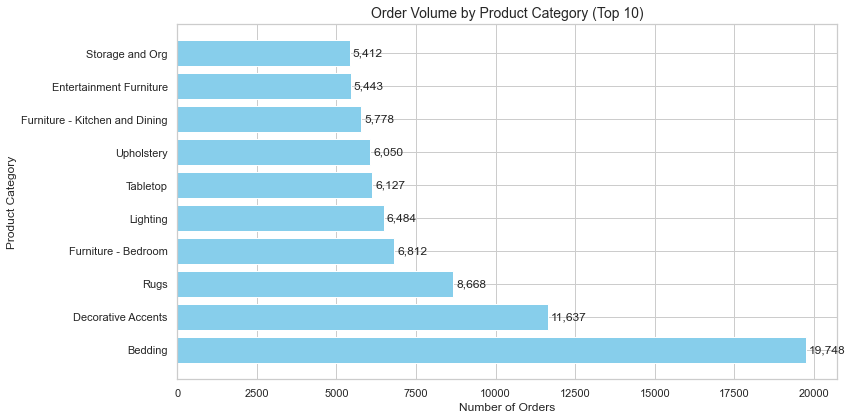

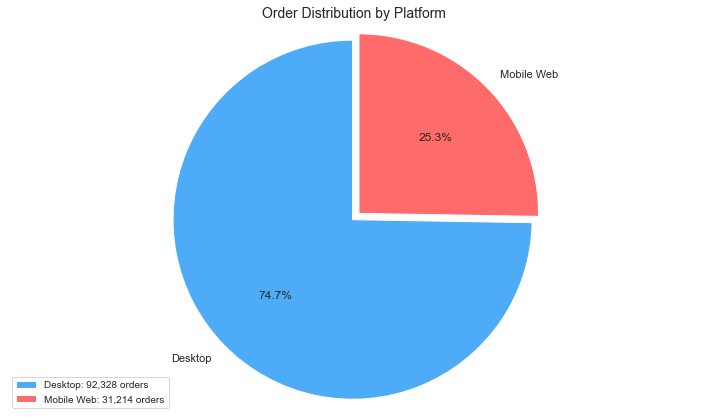

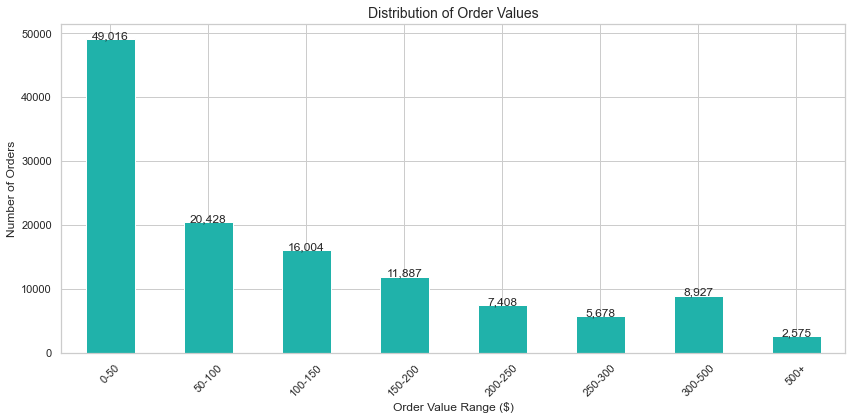

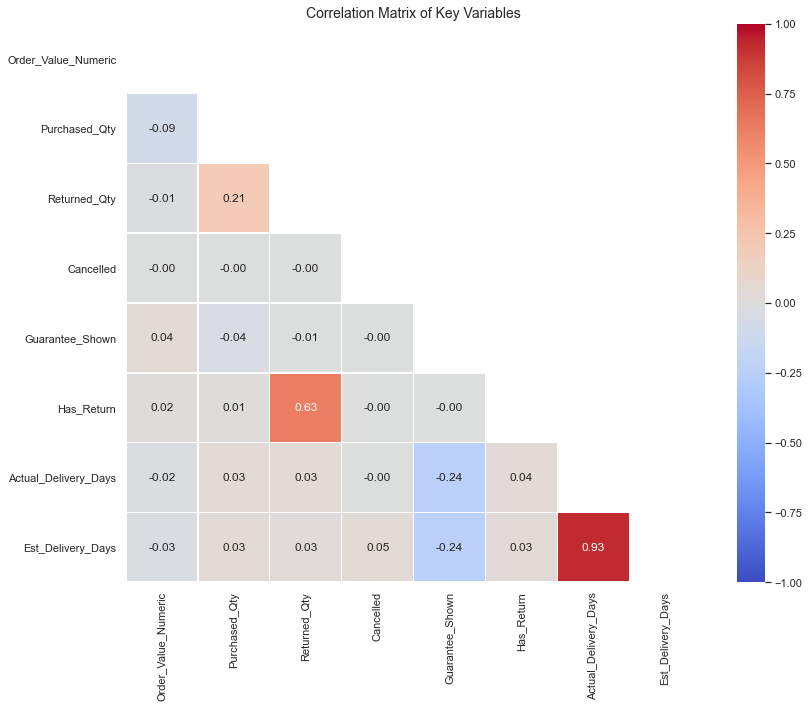

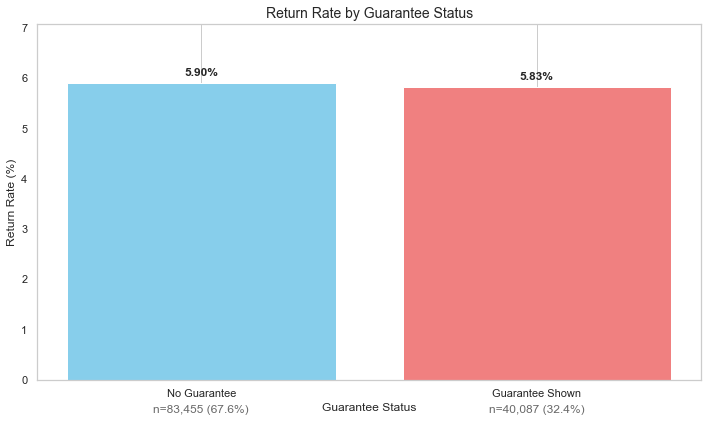

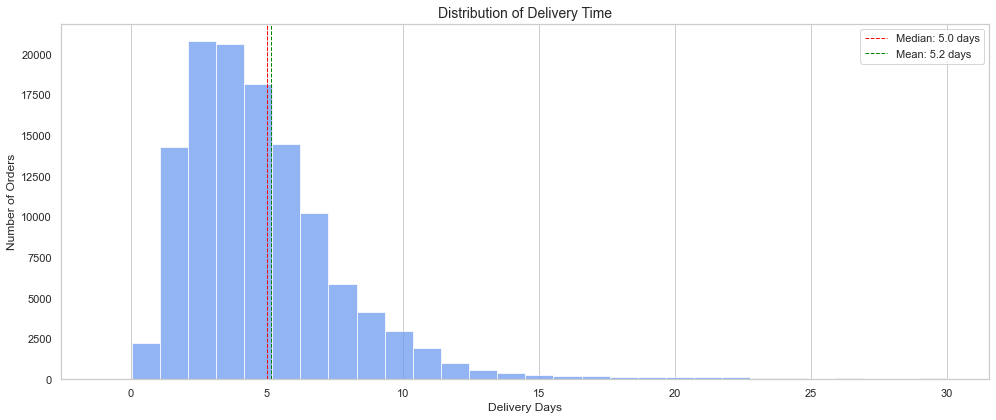

In [51]:
# Generate top product categories chart
plot_category_distribution()

# Generate platform distribution pie chart
plot_platform_distribution()

# View order value distribution
plot_order_value_distribution()

#
plot_correlation_matrix()
#
plot_guarantee_impact()

plot_delivery_time_analysis()

# Part 2: Deep Analysis

## A. Product Category Analysis

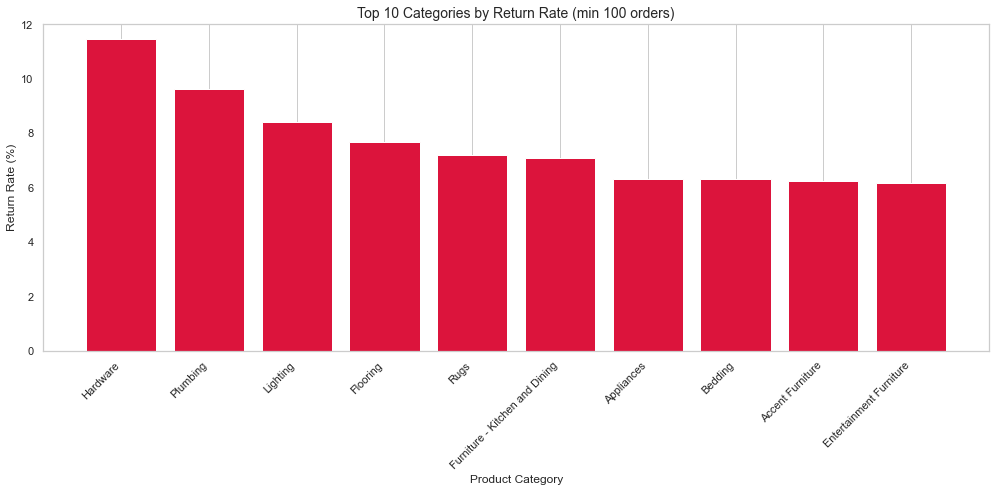

In [52]:
# Calculate return rates by category (minimum 100 orders)
category_metrics = df.groupby('Product_Category').agg({
    'Order_ID': 'count',
    'Has_Return': 'mean',
}).reset_index()

category_metrics['Return_Rate'] = category_metrics['Has_Return'] * 100
category_metrics = category_metrics[category_metrics['Order_ID'] >= 100]  # Filter for categories with at least 100 orders
top_return_categories = category_metrics.sort_values('Return_Rate', ascending=False).head(10)

plt.figure(figsize=(14, 7))
plt.bar(top_return_categories['Product_Category'], top_return_categories['Return_Rate'], color='crimson')
plt.title('Top 10 Categories by Return Rate (min 100 orders)', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Return Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## B. Customer Behavior Analysis

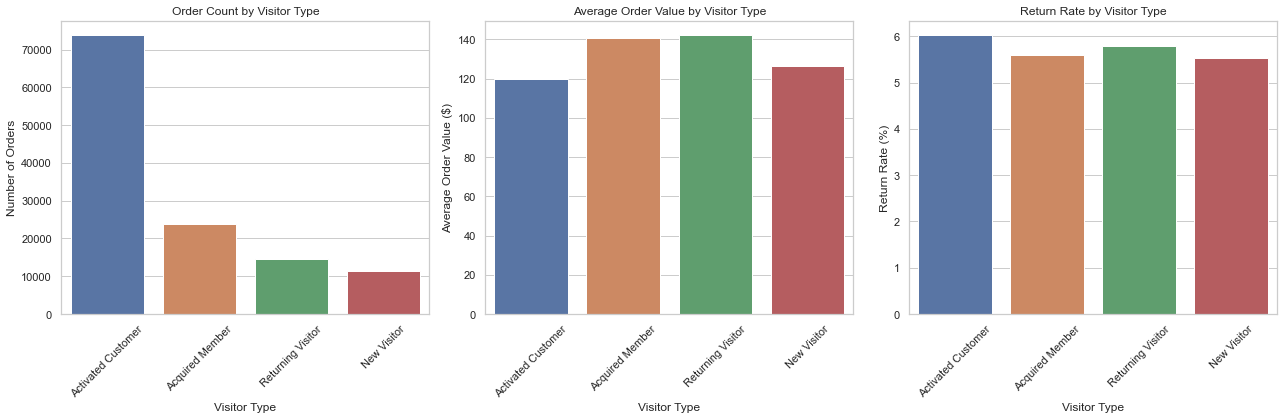

In [53]:
# Visualize metrics by visitor type
visitor_metrics = df.groupby('Vistor_Type_Name').agg({
    'Order_ID': 'count',
    'Order_Value_Numeric': 'mean',
    'Has_Return': 'mean',
    'Is_Cancelled': 'mean'
}).reset_index()
visitor_metrics['Return_Rate'] = visitor_metrics['Has_Return'] * 100
visitor_metrics['Cancellation_Rate'] = visitor_metrics['Is_Cancelled'] * 100
visitor_metrics = visitor_metrics.sort_values('Order_ID', ascending=False)

# Create a multi-metric visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Order Count
sns.barplot(x='Vistor_Type_Name', y='Order_ID', data=visitor_metrics, ax=axes[0])
axes[0].set_title('Order Count by Visitor Type')
axes[0].set_xlabel('Visitor Type')
axes[0].set_ylabel('Number of Orders')
axes[0].tick_params(axis='x', rotation=45)

# Average Order Value
sns.barplot(x='Vistor_Type_Name', y='Order_Value_Numeric', data=visitor_metrics, ax=axes[1])
axes[1].set_title('Average Order Value by Visitor Type')
axes[1].set_xlabel('Visitor Type')
axes[1].set_ylabel('Average Order Value ($)')
axes[1].tick_params(axis='x', rotation=45)

# Return Rate
sns.barplot(x='Vistor_Type_Name', y='Return_Rate', data=visitor_metrics, ax=axes[2])
axes[2].set_title('Return Rate by Visitor Type')
axes[2].set_xlabel('Visitor Type')
axes[2].set_ylabel('Return Rate (%)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

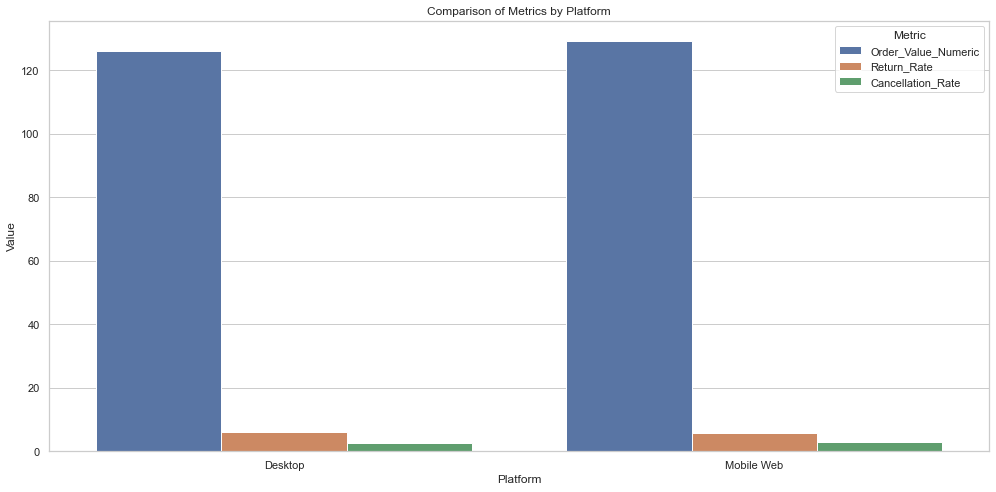

In [54]:
# Compare platform metrics
platform_metrics = df.groupby('Platform_Name').agg({
    'Order_ID': 'count',
    'Order_Value_Numeric': 'mean',
    'Has_Return': 'mean',
    'Is_Cancelled': 'mean'
}).reset_index()
platform_metrics['Return_Rate'] = platform_metrics['Has_Return'] * 100
platform_metrics['Cancellation_Rate'] = platform_metrics['Is_Cancelled'] * 100

# Create a comparison chart
platform_metrics_melted = pd.melt(platform_metrics, 
                                id_vars=['Platform_Name'],
                                value_vars=['Order_Value_Numeric', 'Return_Rate', 'Cancellation_Rate'],
                                var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 7))
sns.barplot(x='Platform_Name', y='Value', hue='Metric', data=platform_metrics_melted)
plt.title('Comparison of Metrics by Platform')
plt.xlabel('Platform')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## C.Delivery Performance Analysis

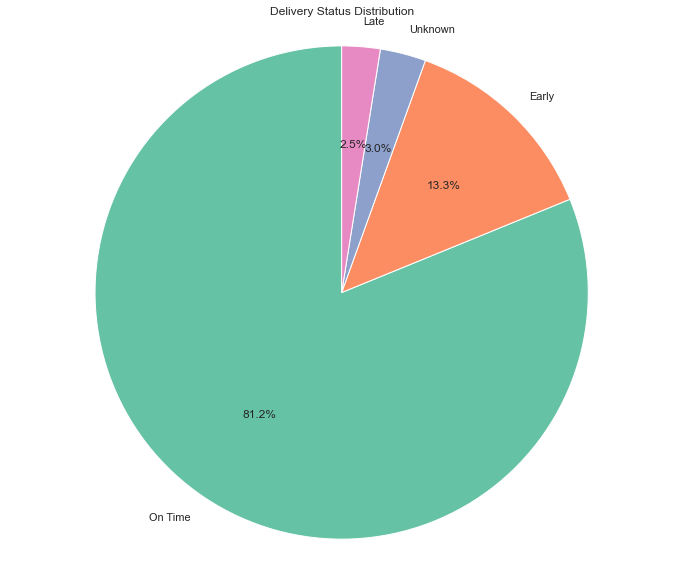

In [55]:
 #Delivery status distribution
delivery_status_counts = df['Delivery_Status'].value_counts()
plt.figure(figsize=(12, 10))
plt.pie(delivery_status_counts, labels=delivery_status_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('Set2'))
plt.title('Delivery Status Distribution')
plt.axis('equal')
plt.show()


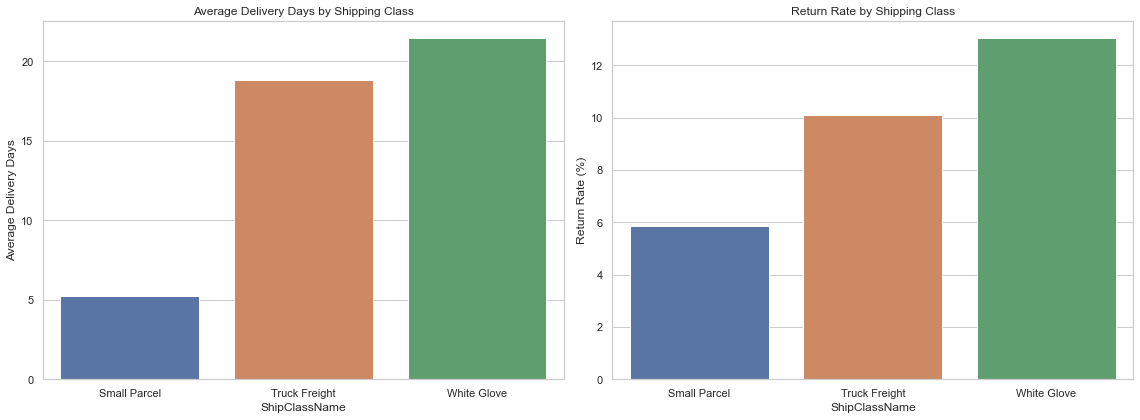

In [56]:
shipping_delivery = df.groupby('ShipClassName').agg({
    'Order_ID': 'count',
    'Actual_Delivery_Days': 'mean',
    'Has_Return': 'mean'
}).reset_index()
shipping_delivery['Return_Rate'] = shipping_delivery['Has_Return'] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average delivery days
sns.barplot(x='ShipClassName', y='Actual_Delivery_Days', data=shipping_delivery, ax=axes[0])
axes[0].set_title('Average Delivery Days by Shipping Class')
axes[0].set_ylabel('Average Delivery Days')

# Return rate
sns.barplot(x='ShipClassName', y='Return_Rate', data=shipping_delivery, ax=axes[1])
axes[1].set_title('Return Rate by Shipping Class')
axes[1].set_ylabel('Return Rate (%)')

plt.tight_layout()
plt.show()


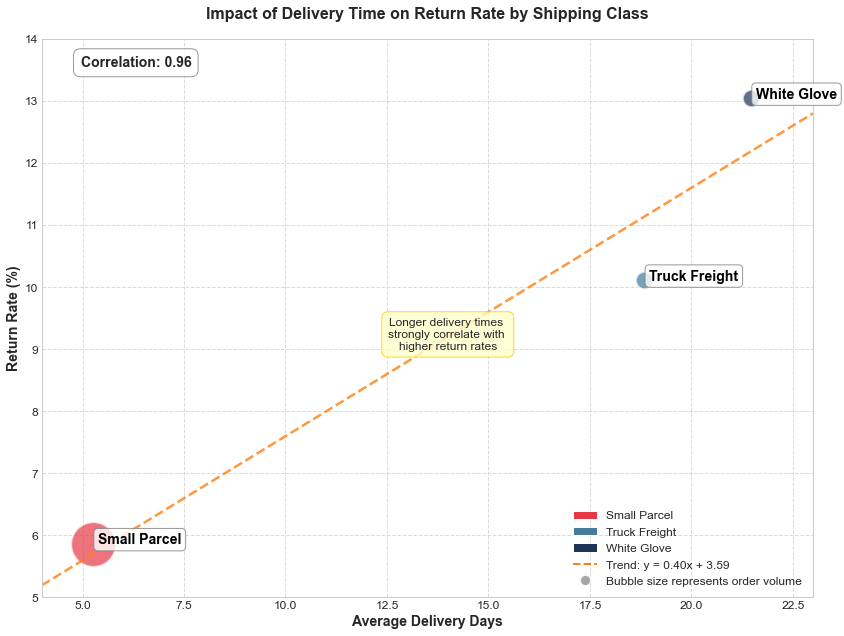

In [57]:
# Enhanced shipping correlation scatter plot with integrated legend
# Moving the bubble size explanation into the legend

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Calculate statistics for each order
df['Is_Late'] = np.where(df['Delivery_Status'] == 'Late', 1, 0)
shipping_correlation = df.groupby('ShipClassName').agg({
    'Order_ID': 'count',
    'Actual_Delivery_Days': 'mean',
    'Has_Return': 'mean',
    'Is_Late': 'mean'
}).reset_index()

shipping_correlation['Return_Rate'] = shipping_correlation['Has_Return'] * 100
shipping_correlation['Late_Delivery_Rate'] = shipping_correlation['Is_Late'] * 100

# Convert pandas Series to numpy arrays
x_values = shipping_correlation['Actual_Delivery_Days'].to_numpy()
y_values = shipping_correlation['Return_Rate'].to_numpy()

# Create a better-looking figure
plt.figure(figsize=(12, 9))

# Set a nicer background
plt.style.use('seaborn-whitegrid')

# Use custom colors for better visibility - each shipping class gets its own distinct color
colors = ['#E63946', '#457B9D', '#1D3557']  # Red, Blue, Dark Blue - colorblind friendly
    
# Create a more attractive scatter plot
for i, row in shipping_correlation.iterrows():
    size = max(300, min(row['Order_ID'] / 50, 2000))  # Better size scaling
    plt.scatter(
        row['Actual_Delivery_Days'], 
        row['Return_Rate'],
        s=size,
        alpha=0.7,
        color=colors[i],
        edgecolor='white',
        linewidth=2
    )
    
    # Add custom-positioned labels with background
    plt.annotate(
        row['ShipClassName'],
        (row['Actual_Delivery_Days'], row['Return_Rate']),
        xytext=(5, 0),
        textcoords='offset points',
        fontsize=14,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8)
    )

# Add trend line
z = np.polyfit(x_values, y_values, 1)
p = np.poly1d(z)

# Generate points for the line
x_range = np.linspace(4, 23, 100)
y_range = p(x_range)

# Draw the trend line with a more sophisticated style
plt.plot(x_range, y_range, linestyle='--', linewidth=2.5, color='#ff7f0e', alpha=0.8)

# Calculate correlation coefficient
corr = np.corrcoef(x_values, y_values)[0, 1]

# Add correlation text in a nicer format
correlation_text = f'Correlation: {corr:.2f}'
plt.annotate(
    correlation_text,
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=14,
    fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.5", 
              fc='white', 
              ec="gray", 
              alpha=0.8)
)

# Add descriptive annotations to explain the relationship
plt.annotate(
    "Longer delivery times \nstrongly correlate with \nhigher return rates",
    xy=(14, 9),
    xycoords='data',
    fontsize=12,
    ha='center',
    bbox=dict(boxstyle="round,pad=0.5", 
              fc='#ffffcc', 
              ec="#ffcc00", 
              alpha=0.8)
)

# Create custom legend elements for shipping classes
shipping_legend_elements = [
    mpatches.Patch(facecolor=colors[i], edgecolor='white', label=row['ShipClassName'])
    for i, row in shipping_correlation.iterrows()
]

# Add trend line to legend elements
trend_line = Line2D([0], [0], color='#ff7f0e', lw=2, linestyle='--', 
                    label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f}')


# Using a scatter point with label explaining the bubble size
bubble_explanation = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                          markersize=10, alpha=0.7, label='Bubble size represents order volume')

# Combine all legend elements
legend_elements = shipping_legend_elements + [trend_line, bubble_explanation]

# Create the combined legend
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, 
           title_fontsize=14, framealpha=0.9, edgecolor='gray')

# Enhance axis labels and title
plt.xlabel('Average Delivery Days', fontsize=14, fontweight='bold')
plt.ylabel('Return Rate (%)', fontsize=14, fontweight='bold')
plt.title('Impact of Delivery Time on Return Rate by Shipping Class', 
          fontsize=16, fontweight='bold', pad=20)

# Set better axis limits
plt.xlim(4, 23)
plt.ylim(5, 14)

# Add grid with better styling
plt.grid(True, linestyle='--', alpha=0.7)

# Make tick labels larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## D: Return Analysis 

## Guarantee Shown factor on user ends vs return rate % metrics

In [58]:

# Basic comparison of return rates
guarantee_returns = df.groupby('Has_Guarantee').agg({
    'Has_Return': 'mean',
    'Order_ID': 'count',
    'Order_Value_Numeric': 'mean',
    'Returned_Qty': 'sum',
    'Purchased_Qty': 'sum'
}).reset_index()

guarantee_returns['Return_Rate'] = guarantee_returns['Has_Return'] * 100
guarantee_returns['Guarantee'] = guarantee_returns['Has_Guarantee'].map({0: 'No Guarantee', 1: 'Guarantee Shown'})
guarantee_returns['Order_Pct'] = (guarantee_returns['Order_ID'] / guarantee_returns['Order_ID'].sum()) * 100
guarantee_returns['Quantity_Return_Rate'] = (guarantee_returns['Returned_Qty'] / guarantee_returns['Purchased_Qty']) * 100

# Display detailed metrics
print("\nDetailed Return Metrics by Guarantee Status:")
print("--------------------------------------------")
for i, row in guarantee_returns.iterrows():
    print(f"{row['Guarantee']}:")
    print(f"  Orders: {row['Order_ID']:,} ({row['Order_Pct']:.1f}% of total)")
    print(f"  Return Rate (Orders): {row['Return_Rate']:.2f}%")
    print(f"  Return Rate (Units): {row['Quantity_Return_Rate']:.2f}%")
    print(f"  Average Order Value: ${row['Order_Value_Numeric']:.2f}")
    print()


Detailed Return Metrics by Guarantee Status:
--------------------------------------------
No Guarantee:
  Orders: 83,455 (67.6% of total)
  Return Rate (Orders): 5.90%
  Return Rate (Units): 6.13%
  Average Order Value: $123.25

Guarantee Shown:
  Orders: 40,087 (32.4% of total)
  Return Rate (Orders): 5.83%
  Return Rate (Units): 6.17%
  Average Order Value: $134.75



## A/B Testing: Guarantee shown by Product Category

A/B TESTING ANALYSIS: IMPACT OF PRODUCT GUARANTEES

1. BASIC A/B TEST ANALYSIS
-----------------------------------------------------

A/B Test Results (Using Existing Data as a Quasi-Experiment):
------------------------------------------------------------
Control Group (No Guarantee): 83,455 orders (67.6%)
Treatment Group (Guarantee): 40,087 orders (32.4%)

Return Rate:
  Control: 5.90%
  Treatment: 5.83%
  Absolute Difference: -0.07 percentage points
  Relative Difference: -1.19%
  p-value: 0.63165663 (Not Statistically Significant)

Average Order Value:
  Control: $123.25
  Treatment: $134.75
  Absolute Difference: $11.50
  Relative Difference: 9.33%


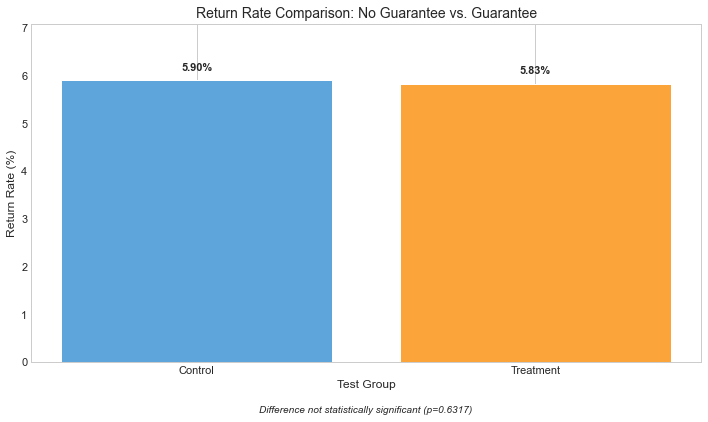

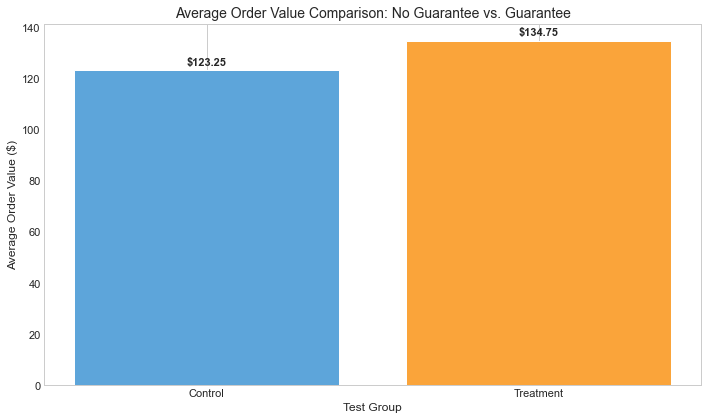


2. SEGMENT-SPECIFIC A/B TEST ANALYSIS
-----------------------------------------------------

Categories where guarantees have most POSITIVE impact (reduce returns):
1. Bedding:
   Control (No Guarantee): 6.57% return rate (n=14,196)
   Treatment (Guarantee): 5.67% return rate (n=5,552)
   Effect: 0.89 percentage point reduction in returns
   p-value: 0.0224 (Significant)

5. Lighting:
   Control (No Guarantee): 8.45% return rate (n=4,285)
   Treatment (Guarantee): 8.32% return rate (n=2,199)
   Effect: 0.13 percentage point reduction in returns
   p-value: 0.8997 (Not Significant)


Categories where guarantees have most NEGATIVE impact (increase returns):
6. Tabletop:
   Control (No Guarantee): 5.42% return rate (n=4,299)
   Treatment (Guarantee): 6.62% return rate (n=1,828)
   Effect: 1.20 percentage point increase in returns
   p-value: 0.0749 (Not Significant)

3. Rugs:
   Control (No Guarantee): 6.81% return rate (n=5,275)
   Treatment (Guarantee): 7.81% return rate (n=3,393)
   E

In [59]:
print("=====================================================")
print("A/B TESTING ANALYSIS: IMPACT OF PRODUCT GUARANTEES")
print("=====================================================")

# 1. Basic A/B test analysis using existing guarantee data
print("\n1. BASIC A/B TEST ANALYSIS")
print("-----------------------------------------------------")

# Group data by guarantee status (our "test groups")
guarantee_ab = df.groupby('Has_Guarantee').agg({
    'Has_Return': ['count', 'sum', 'mean'],
    'Order_Value_Numeric': ['mean', 'std'],
    'Purchased_Qty': ['sum'],
    'Returned_Qty': ['sum']
}).reset_index()

# Flatten the column hierarchy
guarantee_ab.columns = ['_'.join(col).strip('_') for col in guarantee_ab.columns.values]

# Rename columns for clarity
guarantee_ab = guarantee_ab.rename(columns={
    'Has_Guarantee': 'Test_Group',
    'Has_Return_count': 'Sample_Size',
    'Has_Return_sum': 'Returns_Count',
    'Has_Return_mean': 'Return_Rate',
    'Order_Value_Numeric_mean': 'AOV',
    'Order_Value_Numeric_std': 'AOV_Std',
    'Purchased_Qty_sum': 'Units_Purchased',
    'Returned_Qty_sum': 'Units_Returned'
})

# Calculate additional metrics
guarantee_ab['Test_Group'] = guarantee_ab['Test_Group'].map({0: 'Control', 1: 'Treatment'})
guarantee_ab['Return_Rate_Pct'] = guarantee_ab['Return_Rate'] * 100
guarantee_ab['Unit_Return_Rate'] = (guarantee_ab['Units_Returned'] / guarantee_ab['Units_Purchased']) * 100
guarantee_ab['Group_Pct'] = (guarantee_ab['Sample_Size'] / guarantee_ab['Sample_Size'].sum()) * 100

# Statistical testing
# Extract metrics for control and treatment groups
control_data = guarantee_ab[guarantee_ab['Test_Group'] == 'Control']
treatment_data = guarantee_ab[guarantee_ab['Test_Group'] == 'Treatment']

if not control_data.empty and not treatment_data.empty:
    control_returns = control_data['Returns_Count'].values[0]
    control_size = control_data['Sample_Size'].values[0]
    treatment_returns = treatment_data['Returns_Count'].values[0]
    treatment_size = treatment_data['Sample_Size'].values[0]
    
    # Create a contingency table for chi-square test
    contingency = np.array([
        [treatment_returns, treatment_size - treatment_returns],
        [control_returns, control_size - control_returns]
    ])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Calculate absolute and relative differences
    control_rate = control_data['Return_Rate_Pct'].values[0]
    treatment_rate = treatment_data['Return_Rate_Pct'].values[0]
    absolute_diff = treatment_rate - control_rate
    relative_diff = ((treatment_rate / control_rate) - 1) * 100 if control_rate > 0 else float('inf')
    
    # Display detailed results
    print("\nA/B Test Results (Using Existing Data as a Quasi-Experiment):")
    print("------------------------------------------------------------")
    print(f"Control Group (No Guarantee): {control_size:,} orders ({control_data['Group_Pct'].values[0]:.1f}%)")
    print(f"Treatment Group (Guarantee): {treatment_size:,} orders ({treatment_data['Group_Pct'].values[0]:.1f}%)")
    
    print("\nReturn Rate:")
    print(f"  Control: {control_rate:.2f}%")
    print(f"  Treatment: {treatment_rate:.2f}%")
    print(f"  Absolute Difference: {absolute_diff:.2f} percentage points")
    print(f"  Relative Difference: {relative_diff:.2f}%")
    print(f"  p-value: {p_value:.8f} ({'Statistically Significant' if p_value < 0.05 else 'Not Statistically Significant'})")
    
    print("\nAverage Order Value:")
    print(f"  Control: ${control_data['AOV'].values[0]:.2f}")
    print(f"  Treatment: ${treatment_data['AOV'].values[0]:.2f}")
    print(f"  Absolute Difference: ${treatment_data['AOV'].values[0] - control_data['AOV'].values[0]:.2f}")
    print(f"  Relative Difference: {((treatment_data['AOV'].values[0] / control_data['AOV'].values[0]) - 1) * 100:.2f}%")
    
    # Visualize return rate comparison (separate figure)
    plt.figure(figsize=(10, 6))
    
    # Create a bar chart for return rates
    bars = plt.bar(
        guarantee_ab['Test_Group'],
        guarantee_ab['Return_Rate_Pct'],
        color=['#5DA5DA', '#FAA43A']
    )
    
    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.2,
            f"{height:.2f}%",
            ha='center',
            fontsize=11,
            fontweight='bold'
        )
    
    plt.title('Return Rate Comparison: No Guarantee vs. Guarantee', fontsize=14)
    plt.xlabel('Test Group', fontsize=12)
    plt.ylabel('Return Rate (%)', fontsize=12)
    plt.ylim(0, max(guarantee_ab['Return_Rate_Pct']) * 1.2)  # Add space for labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add statistical significance note
    if p_value < 0.05:
        plt.text(0.5, -0.15, f"Statistically significant difference (p={p_value:.4f})",
               ha='center', transform=plt.gca().transAxes, fontsize=10, fontstyle='italic',
               bbox={"boxstyle": "round", "facecolor": "lightgreen", "alpha": 0.8})
    else:
        plt.text(0.5, -0.15, f"Difference not statistically significant (p={p_value:.4f})",
               ha='center', transform=plt.gca().transAxes, fontsize=10, fontstyle='italic',
               bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.8})
    
    plt.tight_layout()
    plt.show()
    
    # Visualize AOV comparison (separate figure)
    plt.figure(figsize=(10, 6))
    
    # Create a bar chart for AOV
    bars = plt.bar(
        guarantee_ab['Test_Group'],
        guarantee_ab['AOV'],
        color=['#5DA5DA', '#FAA43A']
    )
    
    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 2,
            f"${height:.2f}",
            ha='center',
            fontsize=11,
            fontweight='bold'
        )
    
    plt.title('Average Order Value Comparison: No Guarantee vs. Guarantee', fontsize=14)
    plt.xlabel('Test Group', fontsize=12)
    plt.ylabel('Average Order Value ($)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# 2. Segment-specific A/B test analysis
print("\n2. SEGMENT-SPECIFIC A/B TEST ANALYSIS")
print("-----------------------------------------------------")

# Let's analyze guarantee impact (as an A/B test) by product category
# Top 10 categories by volume
top_cats = df['Product_Category'].value_counts().head(10).index.tolist()

# A/B test results by category
cat_ab_results = []

for category in top_cats:
    # Filter data for this category
    cat_df = df[df['Product_Category'] == category]
    
    # Get control and treatment metrics
    control = cat_df[cat_df['Has_Guarantee'] == 0]
    treatment = cat_df[cat_df['Has_Guarantee'] == 1]
    
    # Skip if either group has too few samples
    if len(control) < 30 or len(treatment) < 30:
        continue
    
    # Calculate metrics
    control_returns = control['Has_Return'].mean() * 100
    treatment_returns = treatment['Has_Return'].mean() * 100
    return_diff = treatment_returns - control_returns
    
    control_aov = control['Order_Value_Numeric'].mean()
    treatment_aov = treatment['Order_Value_Numeric'].mean()
    aov_diff = treatment_aov - control_aov
    
    # Statistical testing for returns
    control_return_count = control['Has_Return'].sum()
    treatment_return_count = treatment['Has_Return'].sum()
    
    # Create a contingency table
    contingency = np.array([
        [treatment_return_count, len(treatment) - treatment_return_count],
        [control_return_count, len(control) - control_return_count]
    ])
    
    try:
        chi2, p_value, dof, expected = chi2_contingency(contingency)
    except:
        p_value = 1.0  # If test fails (e.g., due to zero counts)
    
    cat_ab_results.append({
        'Category': category,
        'Control_Size': len(control),
        'Treatment_Size': len(treatment),
        'Control_Returns': control_returns,
        'Treatment_Returns': treatment_returns,
        'Return_Diff': return_diff,
        'Return_p_value': p_value,
        'Control_AOV': control_aov,
        'Treatment_AOV': treatment_aov,
        'AOV_Diff': aov_diff,
        'Significant': p_value < 0.05
    })

if cat_ab_results:
    # Convert to DataFrame and sort
    cat_ab_df = pd.DataFrame(cat_ab_results)
    cat_ab_df = cat_ab_df.sort_values('Return_Diff')
    
    # Display top categories where guarantee helps/hurts
    print("\nCategories where guarantees have most POSITIVE impact (reduce returns):")
    positive_impact = cat_ab_df[cat_ab_df['Return_Diff'] < 0].sort_values('Return_Diff')
    if not positive_impact.empty:
        for i, row in positive_impact.head(3).iterrows():
            print(f"{i+1}. {row['Category']}:")
            print(f"   Control (No Guarantee): {row['Control_Returns']:.2f}% return rate (n={row['Control_Size']:,})")
            print(f"   Treatment (Guarantee): {row['Treatment_Returns']:.2f}% return rate (n={row['Treatment_Size']:,})")
            print(f"   Effect: {abs(row['Return_Diff']):.2f} percentage point reduction in returns")
            print(f"   p-value: {row['Return_p_value']:.4f} ({'Significant' if row['Significant'] else 'Not Significant'})")
            print()
    
    print("\nCategories where guarantees have most NEGATIVE impact (increase returns):")
    negative_impact = cat_ab_df[cat_ab_df['Return_Diff'] > 0].sort_values('Return_Diff', ascending=False)
    if not negative_impact.empty:
        for i, row in negative_impact.head(3).iterrows():
            print(f"{i+1}. {row['Category']}:")
            print(f"   Control (No Guarantee): {row['Control_Returns']:.2f}% return rate (n={row['Control_Size']:,})")
            print(f"   Treatment (Guarantee): {row['Treatment_Returns']:.2f}% return rate (n={row['Treatment_Size']:,})")
            print(f"   Effect: {row['Return_Diff']:.2f} percentage point increase in returns")
            print(f"   p-value: {row['Return_p_value']:.4f} ({'Significant' if row['Significant'] else 'Not Significant'})")
            print()
    else:
        print("No categories have statistically significant results.")

## A/B Tesing: Guarantee Impact by Platform (Desktop and Mobile)

GUARANTEE IMPACT ANALYSIS BY PLATFORM

1. BASIC PLATFORM COMPARISON
-----------------------------------------------------

Guarantee Impact on Return Rate by Platform:

Desktop:
  Orders with Guarantee: 30,087
  Orders without Guarantee: 62,241
  Return Rate with Guarantee: 5.89%
  Return Rate without Guarantee: 6.01%
  Difference: -0.12 percentage points
  AOV with Guarantee: $133.72
  AOV without Guarantee: $122.62
  AOV Difference: $+11.10

Mobile Web:
  Orders with Guarantee: 10,000
  Orders without Guarantee: 21,214
  Return Rate with Guarantee: 5.65%
  Return Rate without Guarantee: 5.58%
  Difference: +0.07 percentage points
  AOV with Guarantee: $137.84
  AOV without Guarantee: $125.09
  AOV Difference: $+12.75

Statistical Significance Testing by Platform:

Desktop:
  Chi-square value: 0.5069
  p-value: 0.47648680
  Statistically significant: No

Mobile Web:
  Chi-square value: 0.0562
  p-value: 0.81255061
  Statistically significant: No

2. VISUALIZING PLATFORM DIFFERENCES
--

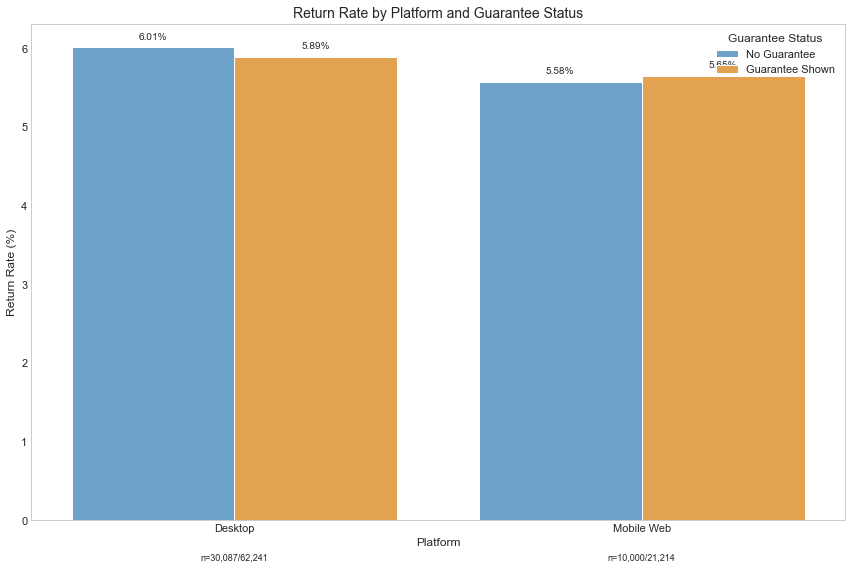

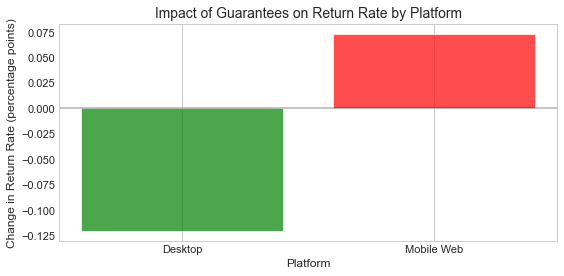


3. GUARANTEE IMPACT BY PLATFORM AND PRODUCT CATEGORY
-----------------------------------------------------
Analyzing guarantee impact across platforms for top 5 categories: Bedding, Decorative Accents, Rugs, Furniture - Bedroom, Lighting

Desktop - Categories where guarantee is MOST effective at reducing returns:
  Bedding: -0.61 percentage point reduction
    (No Guarantee: 6.91%, With Guarantee: 6.30%)
  Furniture - Bedroom: -0.58 percentage point reduction
    (No Guarantee: 5.18%, With Guarantee: 4.60%)

Desktop - Categories where guarantee is LEAST effective or increases returns:
  Rugs: 0.41 percentage point change
    (No Guarantee: 7.01%, With Guarantee: 7.42%)
  Decorative Accents: -0.10 percentage point change
    (No Guarantee: 6.32%, With Guarantee: 6.22%)

Mobile Web - Categories where guarantee is MOST effective at reducing returns:
  Bedding: -1.71 percentage point reduction
    (No Guarantee: 5.59%, With Guarantee: 3.88%)
  Lighting: 0.28 percentage point reduction
   

In [60]:
# Analysis of Guarantee Impact by Platform (Desktop vs Mobile)
# This script examines how guarantees affect returns differently across platforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print("=====================================================")
print("GUARANTEE IMPACT ANALYSIS BY PLATFORM")
print("=====================================================")

# 1. Guarantee impact across platforms
print("\n1. BASIC PLATFORM COMPARISON")
print("-----------------------------------------------------")

# Group by platform and guarantee status
platform_guarantee = df.groupby(['Platform_Name', 'Has_Guarantee']).agg({
    'Has_Return': ['count', 'sum', 'mean'],
    'Order_Value_Numeric': 'mean',
    'Order_ID': 'count'
}).reset_index()

# Flatten the multi-level columns
platform_guarantee.columns = ['_'.join(col).strip('_') for col in platform_guarantee.columns.values]

# Rename for clarity
platform_guarantee = platform_guarantee.rename(columns={
    'Platform_Name': 'Platform',
    'Has_Guarantee': 'Guarantee',
    'Has_Return_count': 'Sample_Size',
    'Has_Return_sum': 'Returns_Count',
    'Has_Return_mean': 'Return_Rate',
    'Order_Value_Numeric_mean': 'AOV',
    'Order_ID_count': 'Order_Count'
})

# Convert return rate to percentage and create labels
platform_guarantee['Return_Rate_Pct'] = platform_guarantee['Return_Rate'] * 100
platform_guarantee['Guarantee_Label'] = platform_guarantee['Guarantee'].map({0: 'No Guarantee', 1: 'Guarantee Shown'})

# Calculate platform-specific metrics
platform_metrics = platform_guarantee.pivot_table(
    index='Platform', 
    columns='Guarantee_Label', 
    values=['Return_Rate_Pct', 'AOV', 'Sample_Size']
).reset_index()

# Flatten the pivoted columns
platform_metrics.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in platform_metrics.columns]

# Calculate differences
if 'Return_Rate_Pct_Guarantee Shown' in platform_metrics.columns and 'Return_Rate_Pct_No Guarantee' in platform_metrics.columns:
    platform_metrics['Return_Rate_Diff'] = (
        platform_metrics['Return_Rate_Pct_Guarantee Shown'] - platform_metrics['Return_Rate_Pct_No Guarantee']
    )
    
if 'AOV_Guarantee Shown' in platform_metrics.columns and 'AOV_No Guarantee' in platform_metrics.columns:
    platform_metrics['AOV_Diff'] = platform_metrics['AOV_Guarantee Shown'] - platform_metrics['AOV_No Guarantee']

# Display platform metrics
print("\nGuarantee Impact on Return Rate by Platform:")
for i, row in platform_metrics.iterrows():
    print(f"\n{row['Platform']}:")
    print(f"  Orders with Guarantee: {row['Sample_Size_Guarantee Shown']:,.0f}")
    print(f"  Orders without Guarantee: {row['Sample_Size_No Guarantee']:,.0f}")
    print(f"  Return Rate with Guarantee: {row['Return_Rate_Pct_Guarantee Shown']:.2f}%")
    print(f"  Return Rate without Guarantee: {row['Return_Rate_Pct_No Guarantee']:.2f}%")
    print(f"  Difference: {row['Return_Rate_Diff']:+.2f} percentage points")
    print(f"  AOV with Guarantee: ${row['AOV_Guarantee Shown']:.2f}")
    print(f"  AOV without Guarantee: ${row['AOV_No Guarantee']:.2f}")
    print(f"  AOV Difference: ${row['AOV_Diff']:+.2f}")

# Perform statistical testing for each platform
print("\nStatistical Significance Testing by Platform:")
platforms = platform_guarantee['Platform'].unique()

for platform in platforms:
    platform_data = platform_guarantee[platform_guarantee['Platform'] == platform]
    
    # Extract data for guarantee vs. no guarantee
    guarantee_row = platform_data[platform_data['Guarantee'] == 1]
    no_guarantee_row = platform_data[platform_data['Guarantee'] == 0]
    
    if len(guarantee_row) > 0 and len(no_guarantee_row) > 0:
        # Create contingency table for chi-square test
        contingency = np.array([
            [guarantee_row['Returns_Count'].values[0], 
             guarantee_row['Sample_Size'].values[0] - guarantee_row['Returns_Count'].values[0]],
            [no_guarantee_row['Returns_Count'].values[0],
             no_guarantee_row['Sample_Size'].values[0] - no_guarantee_row['Returns_Count'].values[0]]
        ])
        
        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            print(f"\n{platform}:")
            print(f"  Chi-square value: {chi2:.4f}")
            print(f"  p-value: {p_value:.8f}")
            print(f"  Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")
        except:
            print(f"\n{platform}: Unable to perform statistical test")

# 2. Visualize platform comparison
print("\n2. VISUALIZING PLATFORM DIFFERENCES")
print("-----------------------------------------------------")

# Create grouped bar chart
plt.figure(figsize=(12, 8))

# Sort platform_guarantee for consistent ordering
platform_guarantee_sorted = platform_guarantee.sort_values(['Platform', 'Guarantee'])

# Plot return rates by platform and guarantee status
ax = sns.barplot(x='Platform', y='Return_Rate_Pct', hue='Guarantee_Label', 
               data=platform_guarantee_sorted, palette=['#5DA5DA', '#FAA43A'])

# Add value labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
           f'{height:.2f}%', ha='center', fontsize=10)

# Add sample size annotations
platforms = platform_guarantee['Platform'].unique()
for i, platform in enumerate(platforms):
    platform_data = platform_guarantee[platform_guarantee['Platform'] == platform]
    guarantee_count = platform_data[platform_data['Guarantee'] == 1]['Sample_Size'].values[0]
    no_guarantee_count = platform_data[platform_data['Guarantee'] == 0]['Sample_Size'].values[0]
    
    plt.text(i, -0.5, f"n={guarantee_count:,}/{no_guarantee_count:,}", ha='center', fontsize=9)

plt.title('Return Rate by Platform and Guarantee Status', fontsize=14)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Return Rate (%)', fontsize=12)
plt.legend(title='Guarantee Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Visualize the difference in return rates
plt.figure(figsize=(8,4))

# Create bar chart of the differences
if 'Return_Rate_Diff' in platform_metrics.columns:
    bars = plt.bar(
        platform_metrics['Platform'], 
        platform_metrics['Return_Rate_Diff'],
        color=['green' if x < 0 else 'red' for x in platform_metrics['Return_Rate_Diff']],
        alpha=0.7
    )
    

    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Impact of Guarantees on Return Rate by Platform', fontsize=14)
    plt.xlabel('Platform', fontsize=12)
    plt.ylabel('Change in Return Rate (percentage points)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 4. Deeper analysis: Compare platform & guarantee impact on different product categories
print("\n3. GUARANTEE IMPACT BY PLATFORM AND PRODUCT CATEGORY")
print("-----------------------------------------------------")

# Get top product categories
top_categories = df['Product_Category'].value_counts().head(5).index.tolist()
print(f"Analyzing guarantee impact across platforms for top 5 categories: {', '.join(top_categories)}")

# Filter for top categories
category_df = df[df['Product_Category'].isin(top_categories)]

# Group by platform, category and guarantee status
platform_cat_guarantee = category_df.groupby(['Platform_Name', 'Product_Category', 'Has_Guarantee']).agg({
    'Has_Return': ['count', 'mean'],
    'Order_ID': 'count'
}).reset_index()

# Flatten the multi-level columns
platform_cat_guarantee.columns = ['_'.join(col).strip('_') for col in platform_cat_guarantee.columns.values]

# Rename for clarity
platform_cat_guarantee = platform_cat_guarantee.rename(columns={
    'Platform_Name': 'Platform',
    'Product_Category': 'Category',
    'Has_Guarantee': 'Guarantee',
    'Has_Return_count': 'Sample_Size',
    'Has_Return_mean': 'Return_Rate',
    'Order_ID_count': 'Order_Count'
})

# Convert return rate to percentage 
platform_cat_guarantee['Return_Rate_Pct'] = platform_cat_guarantee['Return_Rate'] * 100
platform_cat_guarantee['Guarantee_Label'] = platform_cat_guarantee['Guarantee'].map({0: 'No Guarantee', 1: 'Guarantee Shown'})

# Create a pivot table for easier analysis
pivot = platform_cat_guarantee.pivot_table(
    index=['Platform', 'Category'], 
    columns='Guarantee',
    values='Return_Rate_Pct'
).reset_index()

# Rename columns
pivot.columns = ['Platform', 'Category', 'No_Guarantee', 'With_Guarantee']

# Calculate the difference
pivot['Difference'] = pivot['With_Guarantee'] - pivot['No_Guarantee']

# Extract insights
desktop_best = pivot[pivot['Platform'] == 'Desktop'].sort_values('Difference').head(2)
desktop_worst = pivot[pivot['Platform'] == 'Desktop'].sort_values('Difference', ascending=False).head(2)

mobile_best = pivot[pivot['Platform'] == 'Mobile Web'].sort_values('Difference').head(2)
mobile_worst = pivot[pivot['Platform'] == 'Mobile Web'].sort_values('Difference', ascending=False).head(2)

# Print insights
print("\nDesktop - Categories where guarantee is MOST effective at reducing returns:")
for i, row in desktop_best.iterrows():
    print(f"  {row['Category']}: {row['Difference']:.2f} percentage point reduction")
    print(f"    (No Guarantee: {row['No_Guarantee']:.2f}%, With Guarantee: {row['With_Guarantee']:.2f}%)")

print("\nDesktop - Categories where guarantee is LEAST effective or increases returns:")
for i, row in desktop_worst.iterrows():
    print(f"  {row['Category']}: {row['Difference']:.2f} percentage point change")
    print(f"    (No Guarantee: {row['No_Guarantee']:.2f}%, With Guarantee: {row['With_Guarantee']:.2f}%)")

print("\nMobile Web - Categories where guarantee is MOST effective at reducing returns:")
for i, row in mobile_best.iterrows():
    print(f"  {row['Category']}: {row['Difference']:.2f} percentage point reduction")
    print(f"    (No Guarantee: {row['No_Guarantee']:.2f}%, With Guarantee: {row['With_Guarantee']:.2f}%)")

print("\nMobile Web - Categories where guarantee is LEAST effective or increases returns:")
for i, row in mobile_worst.iterrows():
    print(f"  {row['Category']}: {row['Difference']:.2f} percentage point change")
    print(f"    (No Guarantee: {row['No_Guarantee']:.2f}%, With Guarantee: {row['With_Guarantee']:.2f}%)")

# 5. Conclusion and recommendations
print("\n4. PLATFORM-SPECIFIC GUARANTEE RECOMMENDATIONS")
print("-----------------------------------------------------")

# Get overall platform effects
desktop_effect = platform_metrics[platform_metrics['Platform'] == 'Desktop']['Return_Rate_Diff'].values[0]
mobile_effect = platform_metrics[platform_metrics['Platform'] == 'Mobile Web']['Return_Rate_Diff'].values[0]

print("Based on the analysis of guarantee impact across platforms, we recommend:")

if desktop_effect < 0 and mobile_effect < 0:
    print("• Maintain guarantees across both platforms as they reduce returns on both Desktop and Mobile")
    if abs(desktop_effect) > abs(mobile_effect):
        print(f"• Emphasize guarantees more on Desktop where they have a stronger effect ({desktop_effect:.2f} vs {mobile_effect:.2f})")
    else:
        print(f"• Emphasize guarantees more on Mobile where they have a stronger effect ({mobile_effect:.2f} vs {desktop_effect:.2f})")
        
elif desktop_effect < 0:
    print(f"• Keep guarantees on Desktop where they reduce returns by {abs(desktop_effect):.2f} percentage points")
    print(f"• Consider revising or A/B testing guarantee wording on Mobile where they increase returns by {mobile_effect:.2f} percentage points")
    
elif mobile_effect < 0:
    print(f"• Keep guarantees on Mobile where they reduce returns by {abs(mobile_effect):.2f} percentage points")
    print(f"• Consider revising or A/B testing guarantee wording on Desktop where they increase returns by {desktop_effect:.2f} percentage points")
    
else:
    print("• Reconsider the current guarantee strategy as it appears to increase returns on both platforms")
    print("• Prioritize A/B testing different guarantee wording, positioning or selective category deployment")

# Platform-specific category recommendations
print("\nCategory-specific recommendations:")

# Desktop recommendations
print("\nFor Desktop:")
if len(desktop_best) > 0 and desktop_best['Difference'].min() < 0:
    print(f"• Maintain or expand guarantees for {desktop_best.iloc[0]['Category']} where they reduce returns by {abs(desktop_best.iloc[0]['Difference']):.2f} percentage points")
if len(desktop_worst) > 0 and desktop_worst['Difference'].max() > 0:
    print(f"• Consider removing guarantees for {desktop_worst.iloc[0]['Category']} where they increase returns by {desktop_worst.iloc[0]['Difference']:.2f} percentage points")

# Mobile recommendations
print("\nFor Mobile Web:")
if len(mobile_best) > 0 and mobile_best['Difference'].min() < 0:
    print(f"• Maintain or expand guarantees for {mobile_best.iloc[0]['Category']} where they reduce returns by {abs(mobile_best.iloc[0]['Difference']):.2f} percentage points")
if len(mobile_worst) > 0 and mobile_worst['Difference'].max() > 0:
    print(f"• Consider removing guarantees for {mobile_worst.iloc[0]['Category']} where they increase returns by {mobile_worst.iloc[0]['Difference']:.2f} percentage points")

print("\nNext steps:")
print("• Run a proper randomized A/B test stratified by platform and product category")
print("• Test different guarantee wording optimized for each platform's user experience")
print("• Consider platform-specific guarantee presentation styles that align with user behavior")

## Analysis of Guarantee Impact by Delivery Status

Overall Return Rate: 5.88%


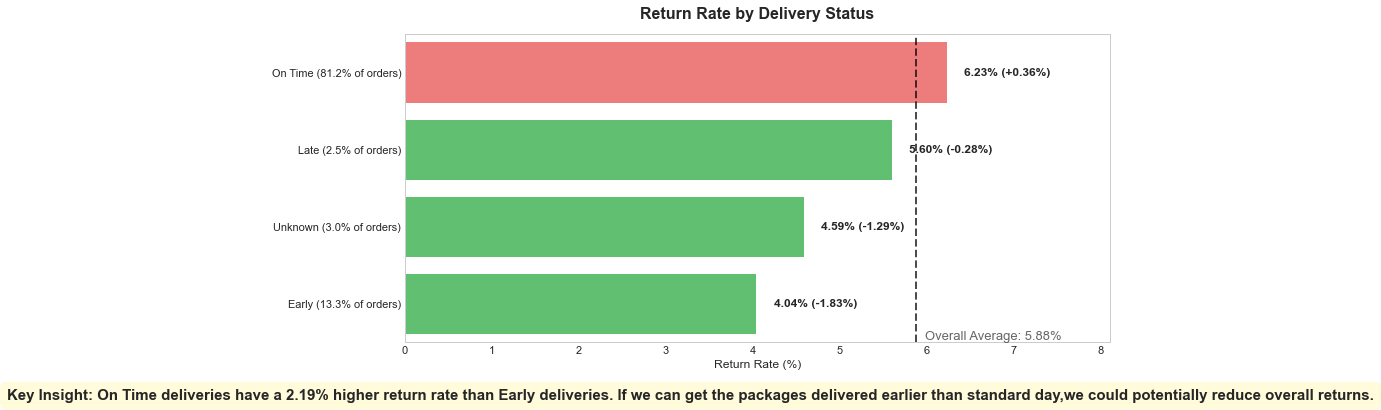

In [61]:
# Horizontal Bar Chart for Return Rate by Delivery Status
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Calculate overall return rate
overall_return_rate = df['Has_Return'].mean() * 100
print(f"Overall Return Rate: {overall_return_rate:.2f}%")

# Calculate return rate by delivery status
delivery_returns = df.groupby('Delivery_Status').agg({
    'Has_Return': 'mean',
    'Order_ID': 'count'
}).reset_index()

delivery_returns['Return_Rate'] = delivery_returns['Has_Return'] * 100
delivery_returns['Order_Pct'] = (delivery_returns['Order_ID'] / delivery_returns['Order_ID'].sum()) * 100

# Sort by return rate (highest first) for better visualization
delivery_returns = delivery_returns.sort_values('Return_Rate', ascending=False)

# Calculate the difference from overall rate for color coding
delivery_returns['Vs_Overall'] = delivery_returns['Return_Rate'] - overall_return_rate

# Create a custom color palette based on difference from overall
# Red for higher than average, green for lower than average
colors = ['#ff6b6b' if x > 0 else '#51cf66' for x in delivery_returns['Vs_Overall']]

# Create more descriptive status labels 
delivery_returns['Status_Label'] = delivery_returns['Delivery_Status'] + ' (' + \
                                  delivery_returns['Order_Pct'].round(1).astype(str) + '% of orders)'

# Create horizontal bar chart with custom colors
plt.figure(figsize=(12, 6))

# Create the horizontal bars
ax = sns.barplot(y='Status_Label', x='Return_Rate', 
               data=delivery_returns, 
               palette=colors,
               orient='h')

# Add value labels to the bars
for i, v in enumerate(delivery_returns['Return_Rate']):
    diff = delivery_returns['Vs_Overall'].iloc[i]
    label = f"{v:.2f}% ({diff:+.2f}%)"
    ax.text(v + 0.2, i, label, va='center', fontweight='bold')

# Add a vertical line for the overall average
plt.axvline(x=overall_return_rate, color='black', linestyle='--', linewidth=2, alpha=0.7)
plt.text(overall_return_rate + 0.1, len(delivery_returns) - 0.5, 
        f'Overall Average: {overall_return_rate:.2f}%', 
        va='bottom', ha='left', fontsize=13, alpha=0.7)

# Enhanced styling
plt.title('Return Rate by Delivery Status', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Return Rate (%)', fontsize=12)
plt.ylabel('')  # Remove y-axis label as the status labels are self-explanatory
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Expand the x-axis a bit to make room for labels
x_max = max(delivery_returns['Return_Rate']) * 1.3
plt.xlim(0, x_max)

# Add insight annotation
highest_status = delivery_returns['Delivery_Status'].iloc[0]
lowest_status = delivery_returns['Delivery_Status'].iloc[-1]
highest_rate = delivery_returns['Return_Rate'].iloc[0]
lowest_rate = delivery_returns['Return_Rate'].iloc[-1]
diff = highest_rate - lowest_rate

insight_text = (
    f"Key Insight: {highest_status} deliveries have a {diff:.2f}% higher return rate than {lowest_status} deliveries. "
    f"If we can get the packages delivered earlier than standard day,we could potentially reduce overall returns."
)

plt.figtext(0.5, 0.01, insight_text, ha='center', fontsize=15,fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='#fffacd', alpha=0.7))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for the insight text
plt.show()

# Part 3: Data Experiments + Strategic Recommendations

## A. Customer Segmentation Experiment 

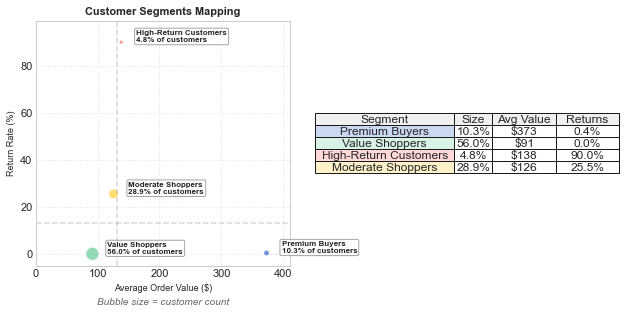

In [62]:
# Fixed Compact Customer Segmentation Visualizatione

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data based on the cluster analysis 
cluster_data = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Customer_Count': [12687, 69215, 5913, 35727],  # Estimated for cluster 3
    'Order_Count': [1.13, 1.17, 1.27, 1.21],  # Average orders per customer
    'Avg_Order_Value': [373.29, 91.38, 137.99, 125.50],  # Estimated for cluster 3
    'Return_Rate': [0.37, 0.00, 90.04, 25.50],  # Estimated for cluster 3
    'Avg_Delivery_Days': [5.17, 5.25, 5.83, 6.02]  # Estimated for cluster 3
})

# Add business-friendly segment names
def assign_segment_name(row):
    if row['Avg_Order_Value'] > 300 and row['Return_Rate'] < 1:
        return "Premium Buyers"
    elif row['Return_Rate'] < 1:
        return "Value Shoppers"
    elif row['Return_Rate'] > 50:
        return "High-Return Customers"
    else:
        return "Moderate Shoppers"

cluster_data['Segment'] = cluster_data.apply(assign_segment_name, axis=1)

# Calculate total customer base for percentages
total_customers = cluster_data['Customer_Count'].sum()
cluster_data['Customer_Pct'] = (cluster_data['Customer_Count'] / total_customers) * 100

# Set colors for each segment
segment_colors = {
    "Premium Buyers": "#3366CC",      # Blue
    "Value Shoppers": "#66CC99",      # Green
    "High-Return Customers": "#FF6666", # Red
    "Moderate Shoppers": "#FFCC33"    # Yellow
}
cluster_data['Color'] = cluster_data['Segment'].map(segment_colors)

# Create a compact figure with two panels side by side
plt.figure(figsize=(10, 4.5))

# Left panel: Quadrant chart with bubble size representing customer count
ax1 = plt.subplot(1, 2, 1)

# Create the quadrant chart
plt.scatter(
    cluster_data['Avg_Order_Value'],
    cluster_data['Return_Rate'],
    s=cluster_data['Customer_Count'] / 400,  # Smaller bubbles for compact view
    c=cluster_data['Color'],
    alpha=0.7,
    edgecolors='white',
    linewidth=1
)

# Add segment name labels with condensed info
for i, row in cluster_data.iterrows():
    # Add label with segment name and key stats
    label = f"{row['Segment']}\n{row['Customer_Pct']:.1f}% of customers"
    plt.annotate(
        label,
        (row['Avg_Order_Value'], row['Return_Rate']),
        xytext=(15, 0),
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec='gray', alpha=0.7)
    )

# Add quadrant lines at median values for better interpretation
median_order_value = cluster_data['Avg_Order_Value'].median()
median_return_rate = cluster_data['Return_Rate'].median()
plt.axvline(x=median_order_value, color='gray', linestyle='--', alpha=0.3)
plt.axhline(y=median_return_rate, color='gray', linestyle='--', alpha=0.3)

# Set labels and limits
plt.xlabel('Average Order Value ($)', fontsize=9)
plt.ylabel('Return Rate (%)', fontsize=9)
plt.title('Customer Segments Mapping', fontsize=11, fontweight='bold')
plt.xlim(0, max(cluster_data['Avg_Order_Value']) * 1.1)
plt.ylim(-5, max(cluster_data['Return_Rate']) * 1.1)
plt.grid(True, linestyle='--', alpha=0.3)

# Add a tiny note about bubble size
plt.text(0.5, -0.15, 'Bubble size = customer count',
        ha='center', va='center', transform=ax1.transAxes, 
        fontsize=10, fontstyle='italic', alpha=0.7)

# Right panel: Segment Metrics Table with embedded small bars
ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')  # Turn off axis

# Create a visually enhanced table
table_data = []
for i, row in cluster_data.iterrows():
    segment_row = [
        row['Segment'],
        f"{row['Customer_Pct']:.1f}%",
        f"${row['Avg_Order_Value']:.0f}",
        f"{row['Return_Rate']:.1f}%"
    ]
    table_data.append(segment_row)

# Add a header row
table_data.insert(0, ['Segment', 'Size', 'Avg Value', 'Returns'])

# Create table with embedded color coding
cell_colors = []
for i in range(len(table_data)):
    if i == 0:  # Header row
        cell_colors.append(['#f0f0f0', '#f0f0f0', '#f0f0f0', '#f0f0f0'])
    else:
        segment = table_data[i][0]
        color = segment_colors.get(segment, 'white')
        # Color only the segment name cell, make others white
        cell_colors.append([color + '40', 'white', 'white', 'white'])  # Add alpha with '40'

# Create the table
segment_table = ax2.table(
    cellText=table_data,
    cellColours=cell_colors,
    loc='center',
    cellLoc='center',
    colWidths=[0.55, 0.15, 0.25, 0.25]
)

# Style the table
segment_table.auto_set_font_size(False)

### Strategic Investment Recommendation

Based on our customer segmentation analysis, we recommend the following targeted allocation of marketing and operational resources:

- ** 40% – Value Shoppers**
  - Represent **56%** of total customers
  - Average Order Value (AOV): **$91.38**
  - **0% return rate**
  - **Goal:** Increase purchase frequency (currently 1.17 orders per customer) via loyalty perks, cross-sells, and time-based reactivation campaigns.

- ** 35% – Premium Buyers**
  - Represent **10%** of total customers
  - AOV: **$373.29**
  - Return rate: **0.37%**
  - **Goal:** Grow this high-value, low-risk segment through **look-alike acquisition**, tiered loyalty programs, and high-end personalized marketing.

- ** 15% – High-Return Customers**
  - Represent **5%** of total customers
  - AOV: **$137.99**
  - Return rate: **90.04%**
  - **Goal:** Reduce margin erosion via **pre-purchase education**, sizing guidance, and enhanced **product visualization** (e.g., AR previews, demo videos).

- ** 10% – Moderate Shoppers**
  - Represent **29%** of customers
  - AOV: **$125.50**
  - Return rate: **25.50%**
  - **Goal:** Shift behavior toward Premium/Value profiles via **return policy nudging**, checkout reinforcement, and tailored messaging.

> This investment framework prioritizes both **profit growth** and **cost containment** by expanding high-value segments while addressing operational inefficiencies driven by concentrated return behaviors.